###Part 1


Our final project of the course will discuss, analyze and model some of the data arising from the stock market more specifically the stock value of Netflix. the data can be found at https://www.kaggle.com/datasets/camnugent/sandp500?resource=download The project is going to focus on the fluctuation and especially the rise this stock value. The data spreads over five years from february 2013 till february 2018. it holds the open, close, high and low value of the stock at each day and its trade volume.

For part 3 the exogenous variables that we have chosen to introduce are the ammount of new items uploaded each month to netflixs platform. it revolves around the idea that investment yields returns (more items = more investment, return = stock value raises)

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [247]:
# Load the CSV file
stock_df = pd.read_csv('209369909_931203129_1.csv', sep=',')

In [248]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    262 non-null    object 
 1   open    262 non-null    float64
 2   high    262 non-null    float64
 3   low     262 non-null    float64
 4   close   262 non-null    float64
 5   volume  262 non-null    int64  
 6   Name    262 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 14.5+ KB


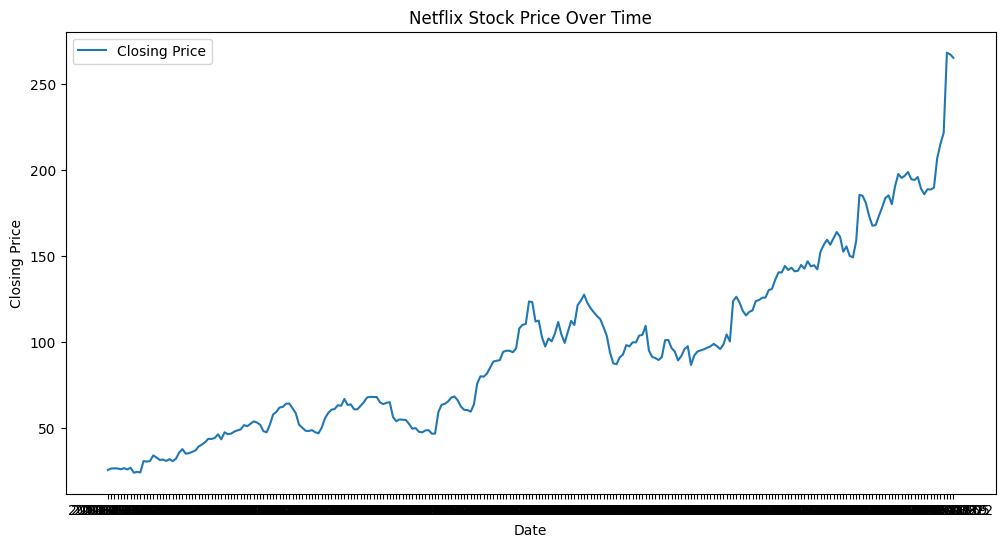

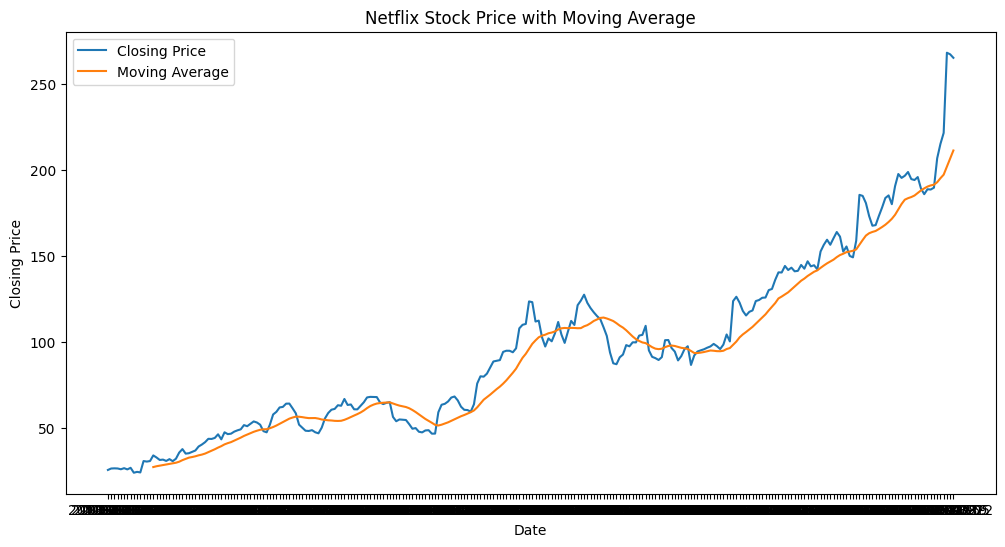

In [249]:
# Plot the closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(stock_df['date'], stock_df['close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Netflix Stock Price Over Time')
plt.legend()
plt.show()

# Calculate the moving average of the closing prices
moving_avg = stock_df['close'].rolling(window=15).mean()

# Plot the closing prices and moving average together
plt.figure(figsize=(12, 6))
plt.plot(stock_df['date'], stock_df['close'], label='Closing Price')
plt.plot(stock_df['date'], moving_avg, label='Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Netflix Stock Price with Moving Average')
plt.legend()
plt.show()

This graph represents the evolution of the stock value over time. its rise is constant over long periods of time, while we may see descending trends. The moving average allows us to smooth things.

In [250]:
from statsmodels.tsa.seasonal import seasonal_decompose

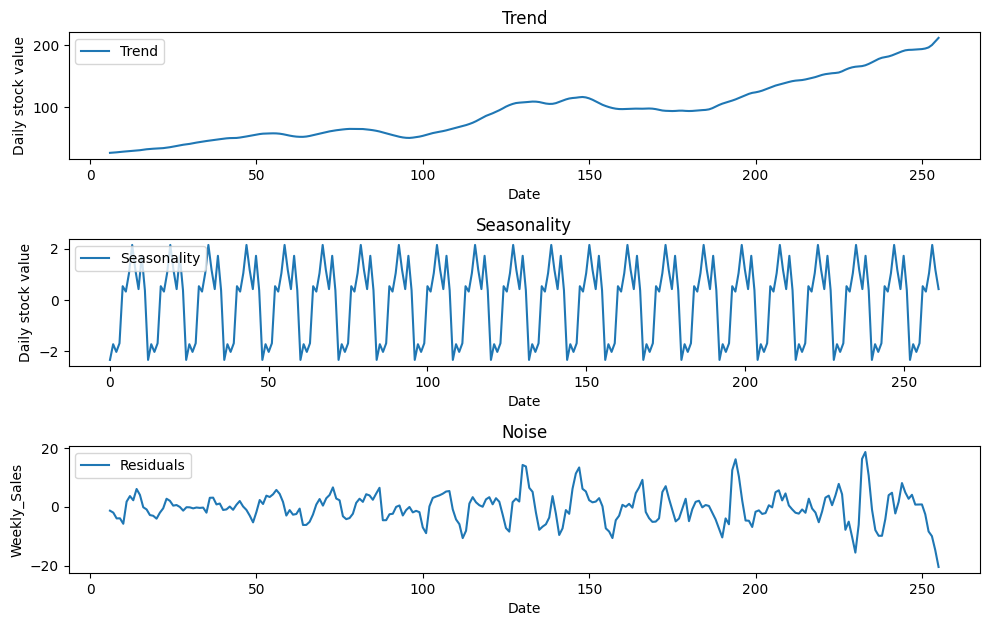

In [251]:
decomposition = seasonal_decompose(stock_df['open'], model='additive', period=12)

# Plot trend, seasonality and noise of the variable
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(stock_df.index, decomposition.trend, label='Trend')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Daily stock value')
plt.legend()

plt.subplot(412)
plt.plot(stock_df.index, decomposition.seasonal, label='Seasonality')
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Daily stock value')
plt.legend()

plt.subplot(413)
plt.plot(stock_df.index, decomposition.resid, label='Residuals')
plt.title('Noise')
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.legend()

plt.tight_layout()
plt.show()

These visualizations reveal discernible trends and seasonality patterns within the data. The presence of seasonality is evident from the regular peaks occurring. Furthermore, consistent noise patterns are apparent, contributing to the overall variability in the data. The graph using the rolling mean renforces our idea.

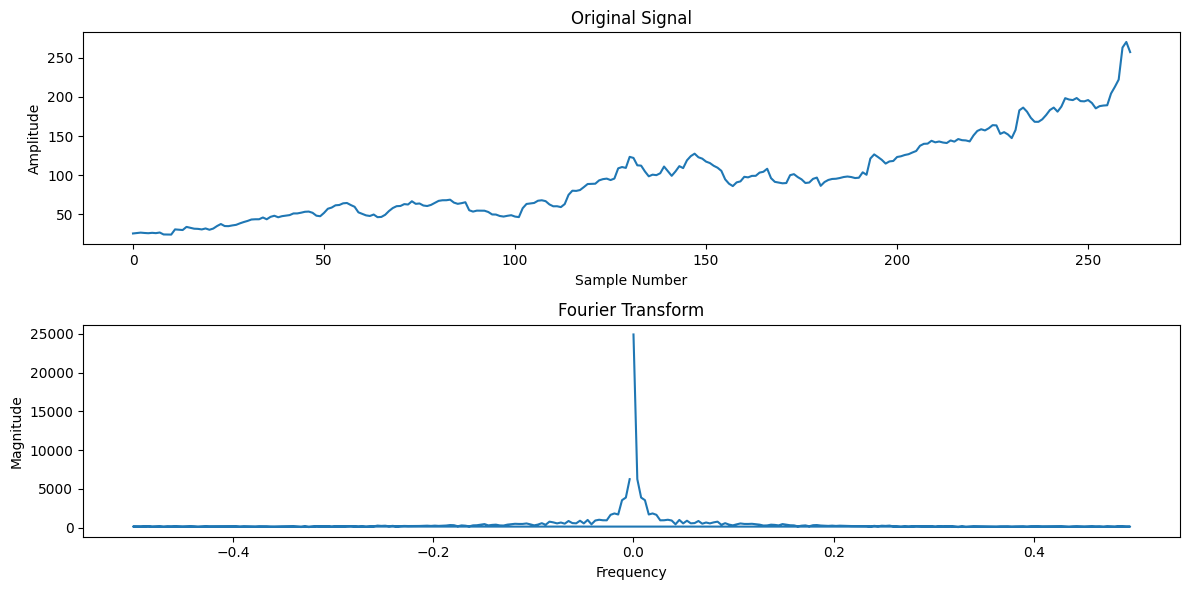

In [252]:
values = stock_df['open']
fft_values = np.fft.fft(values)

# Compute the frequencies
freq = np.fft.fftfreq(len(values))

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(values)
plt.title('Original Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

# Plot the magnitude of the Fourier Transform
plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_values))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

The zero frequency, also known as the DC component, represents the average value or the mean of the signal. There is a significant peak at zero frequency, it implies that the signal has a strong constant component. This prominent peak at zero frequency indicates the constant offset.

The edges of the frequency spectrum represent higher frequencies. The Fourier transform values decay towards zero at the edges, it indicates that high-frequency components (rapid changes in the signal) are not prominent in this signal. This behavior is typical for smooth signals or signals with low-frequency content. A signal with fewer high-frequency components will have most of its energy concentrated at low frequencies (this isn't our case).

###Part 2

###Sarima Model
Let's remember that we have a dataset composed of a 'date' column and a 'value' column. These correspond to the evolution of NETFLIX stock prices between 2013 and 2018. Let's start by analyzing this evolution using the SARIMA model.

In [253]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [254]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [255]:
df=stock_df[['open', 'date']]
df = df.set_index(['date'])

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(-50.0, 0, '2017-03-06'),
  Text(0.0, 0, '2013-05-06'),
  Text(50.0, 0, '2014-04-21'),
  Text(100.0, 0, '2015-04-06'),
  Text(150.0, 0, '2016-03-21'),
  Text(200.0, 0, '2017-03-06'),
  Text(250.0, 0, ''),
  Text(300.0, 0, '')])

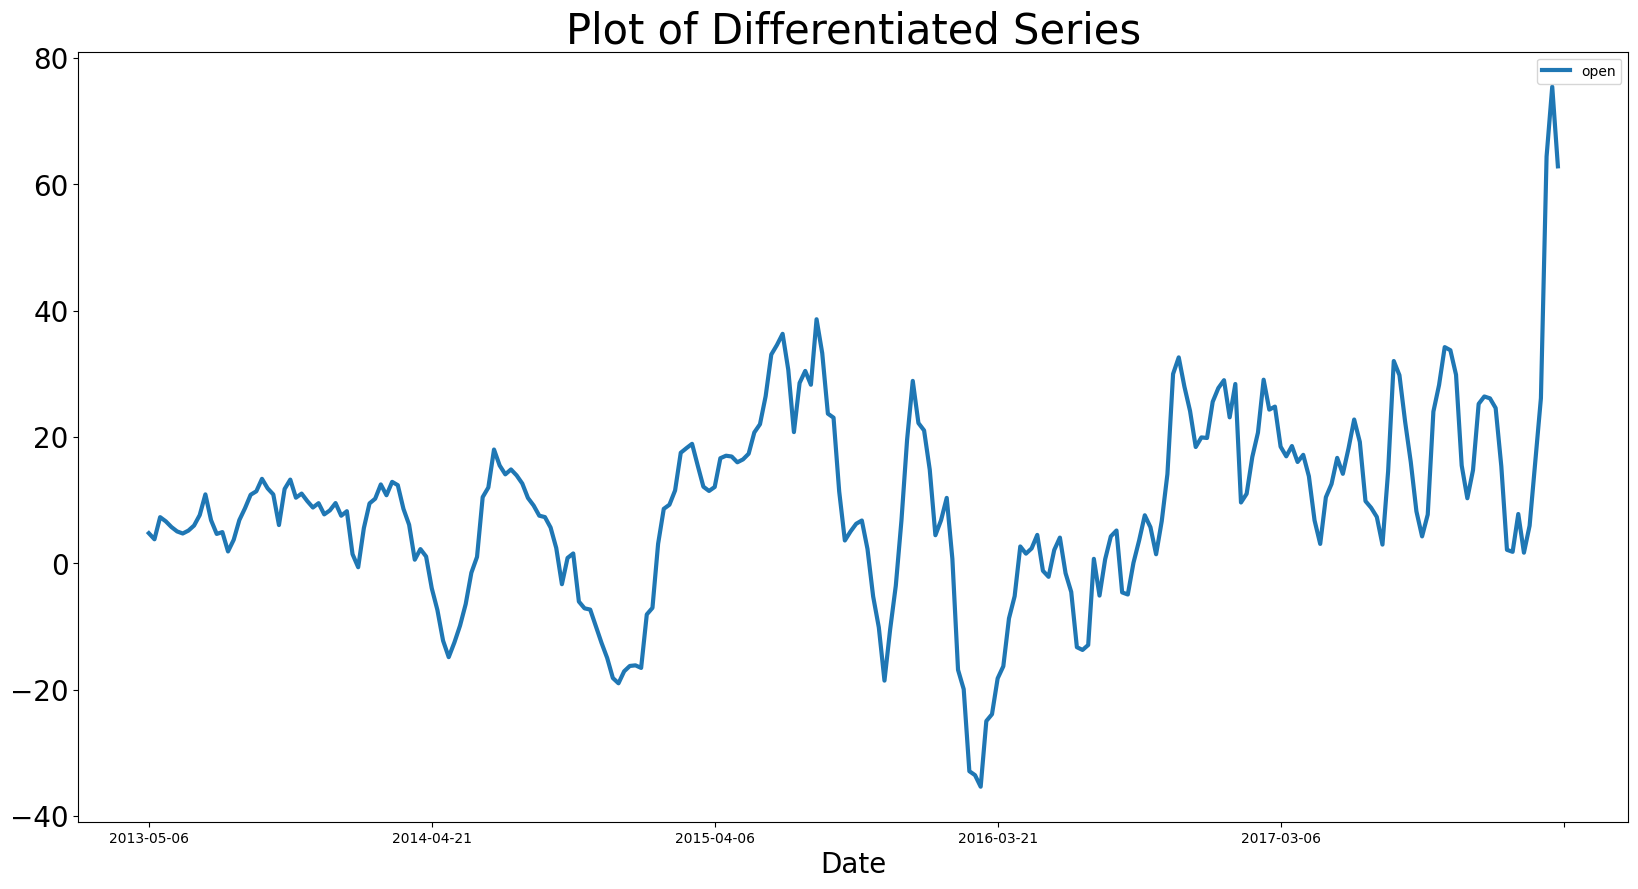

In [256]:
year_diff=df.diff(periods=12)
year_diff=year_diff.dropna()
year_diff.plot(figsize=(20,10), linewidth=3, fontsize=20)
plt.title("Plot of Differentiated Series",fontsize=30)
plt.xlabel('Date', fontsize=20);
plt.xticks(fontsize = 10)

We decided to use a tool in order to estimate the parameter of the SARIMA model.
Let's use pmdarima

Auto arima has the advantage of attempting to find the best ARIMA parameters by comparing the AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) of the tested models, it is not always able to do so; the results could be very similar to those obtained by running the ARIMA algorithm and estimating the parameters “manually,” if not slightly worse.

In [257]:
!pip install pmdarima
import pmdarima as pm

# Use librairy to get the best parameters.
model = pm.auto_arima(df['open'],
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.16 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1604.363, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1591.581, Time=4.05 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1585.547, Time=2.30 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1609.867, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1584.971, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1585.716, Time=2.07 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=13.67 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1584.188, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=1585.229, Time=2.99 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=1585.092, Time=3.55 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=17.33 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1590.987, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=1585.756, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[52] interc

Analyze autocorrelation , partial auto correlation

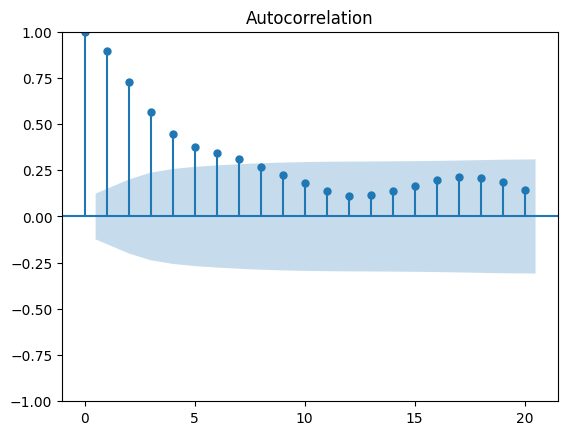

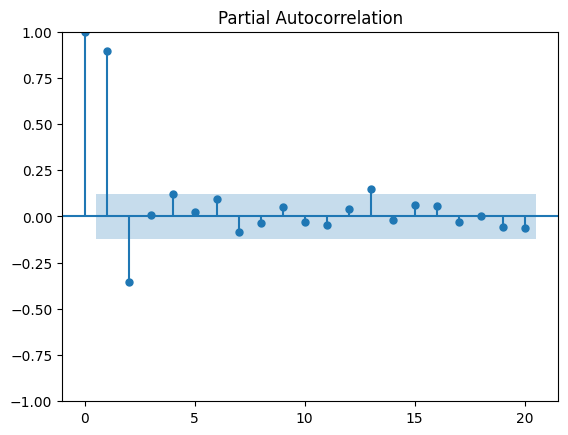

In [258]:
tsaplots.plot_acf(year_diff,lags=20);
tsaplots.plot_pacf(year_diff,lags=20);

Here's an interpretation of the graphs and a suggestion for a model:
The Auto-Correlation plot shows exponential decay, suggesting the presence of seasonal or autoregressive components in the time series.
The Partial Auto-Correlation displays a significant peak at the first lag, indicating a potential AR(1) component in the non-seasonal data.

Non-seasonal parameters (p, d, q):
p: 1 (suggested by the significant peak at the first lag of the PACF) d: 1 is commonly used to make a series stationary.
q: 0 or 1 (depending on the decay rate in the ACF, but often 0 is sufficient with a strong first lag in PACF)

Seasonal parameters (P, D, Q, s):
P (seasonal autoregressive lags): Given the decay in PACF, you might experiment with 0 or 1.
D (seasonal differencing): Typically, a value of 0 or 1 is used, depending on the presence of seasonal trends.
Q (seasonal moving average terms): 0, as there isn’t a strong indication of a seasonal MA component.

Since we got weekly data, we will choose s = 52.

A starting model could be SARIMA(1,1,0)x(0,1,0,52).

In [259]:
seasonal_order_1 = (0, 1, 0, 52)
seasonal_order_2 = (1, 1, 1, 52)
seasonal_order_3 = (0, 1, 1, 52)
seasonal_order_4 = (0, 0, 1, 52)
seasonal_order_5 = (1, 1, 0, 52)

###SARIMA (0,1,2)(0,1,0)(52)

In [260]:
model1 = SARIMAX(df, order=(0, 1, 2),seasonal_order=seasonal_order_1 )
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                open   No. Observations:                  262
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 52)   Log Likelihood                -702.418
Date:                             Thu, 23 May 2024   AIC                           1410.836
Time:                                     18:38:57   BIC                           1420.863
Sample:                                 02-11-2013   HQIC                          1414.890
                                      - 02-12-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2768      0.067      4.109      0.000       0.145       0.409
ma.L2         -0.1191      

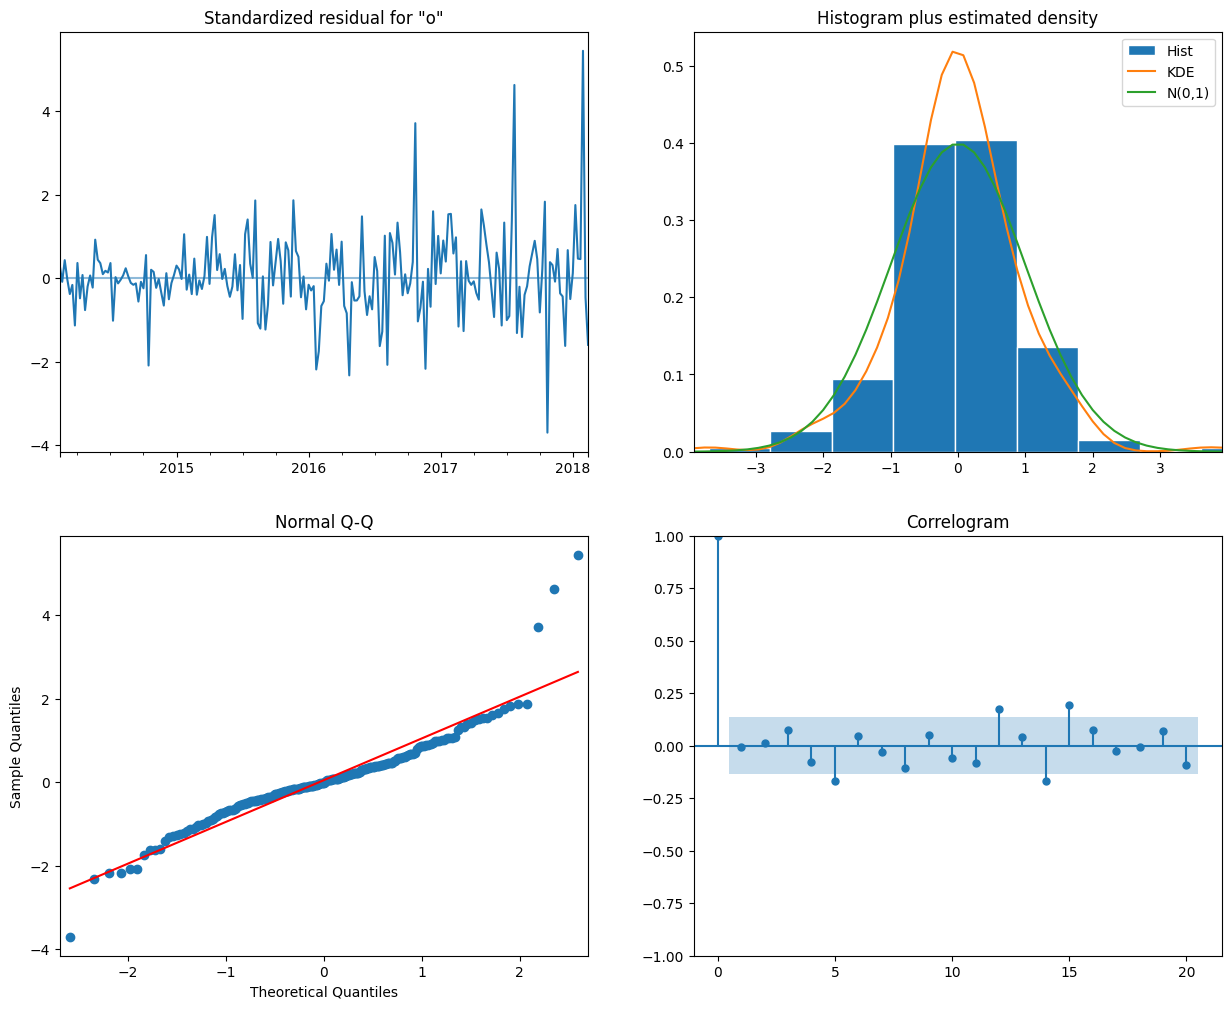

In [261]:
model1_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

In [262]:
TEST_SIZE = int(df.size * 0.15)
train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
x_train, x_test = np.array(train.index.values), np.array(test.index.values)

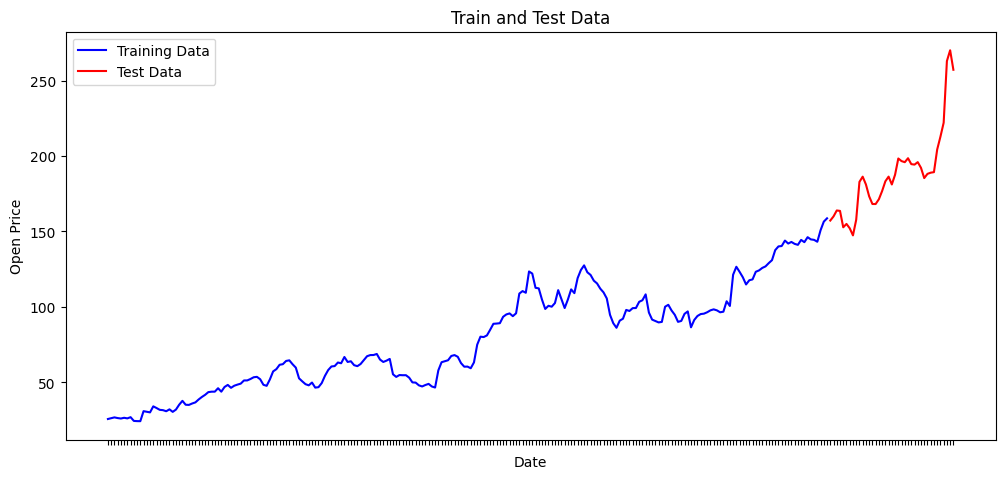

In [263]:
import matplotlib.dates as mdates
plt.figure(figsize=(12, 6))
plt.plot(x_train, train['open'], color='blue', label='Training Data')  # Train data in blue
plt.plot(x_test, test['open'], color='red', label='Test Data')  # Test data in red

# Adding labels
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()

ax = plt.gca()


plt.gcf().autofmt_xdate()
ax.set_xticklabels([])
plt.show()

In [264]:
model_train = SARIMAX(train, order=(0, 1, 2),seasonal_order=seasonal_order_1)
model_train_fit = model_train.fit(disp=False)
print(model_train_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                open   No. Observations:                  223
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 52)   Log Likelihood                -537.136
Date:                             Thu, 23 May 2024   AIC                           1080.272
Time:                                     18:39:02   BIC                           1089.679
Sample:                                 02-11-2013   HQIC                          1084.089
                                      - 05-15-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3153      0.069      4.549      0.000       0.179       0.451
ma.L2          0.0178      

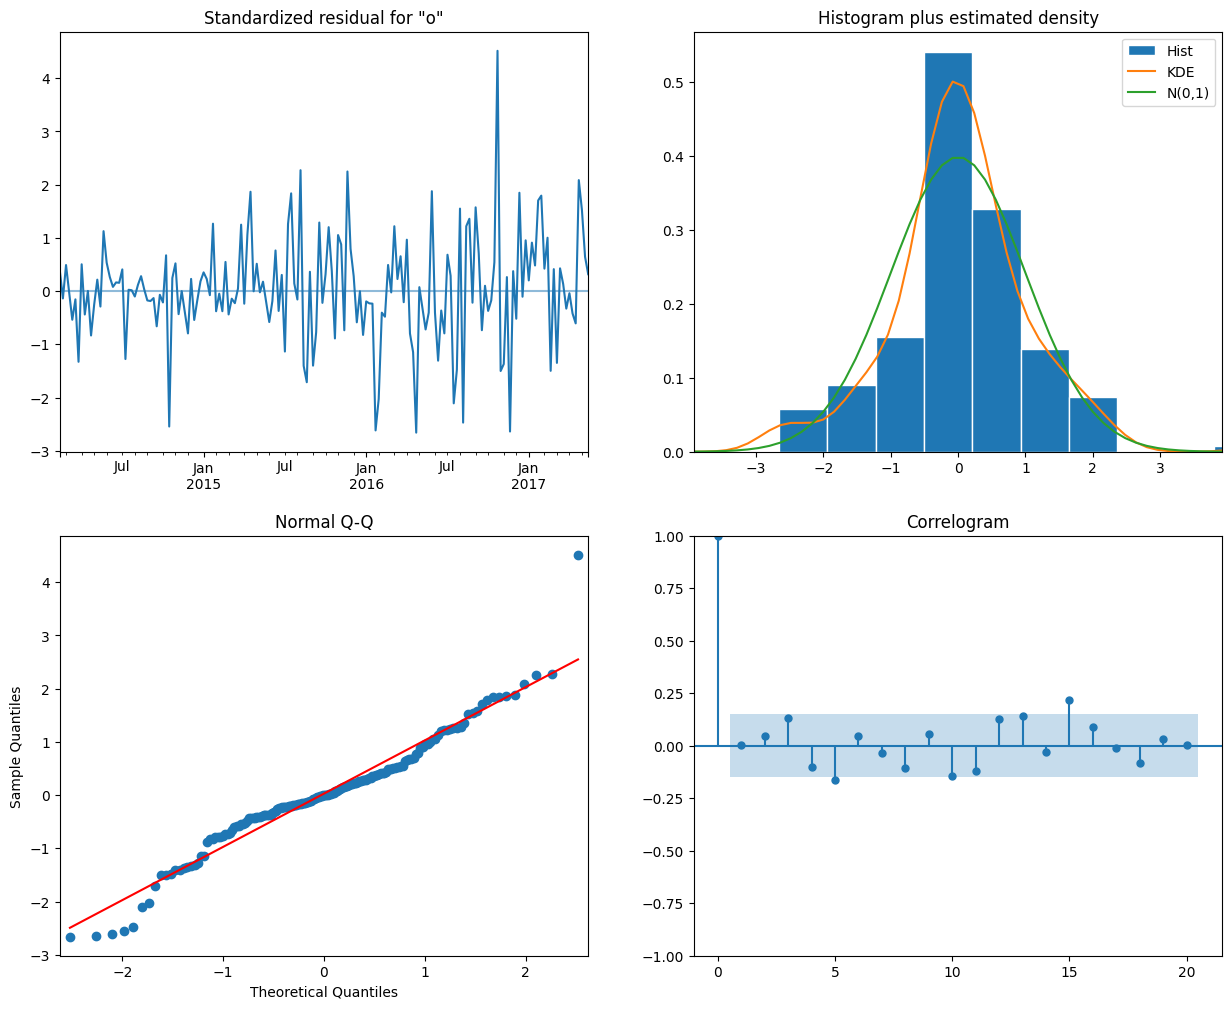

In [265]:
model_train_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

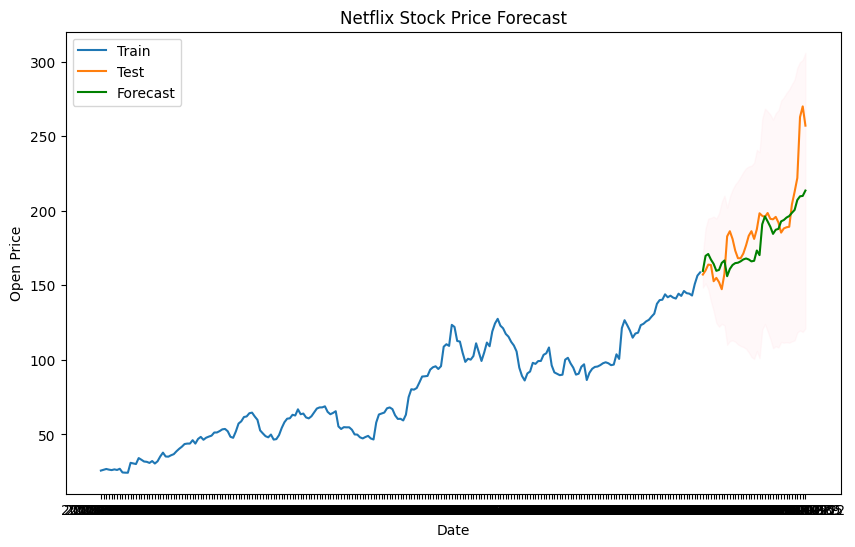

In [266]:
forecast = model_train_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Forecasting
predictions = model_train_fit.forecast(steps=TEST_SIZE)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['open'], label='Train')
plt.plot(test.index, test['open'], label='Test')
plt.plot(test.index, predictions, label='Forecast', color='green')
# Plotting the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.1)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
ax.set_xticklabels([])
plt.show()

In [267]:
# Computing of errors between forecast and test
mae = mean_absolute_error(test['open'], predictions)
mse = mean_squared_error(test['open'] , predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Absolute Error: 13.31
Mean Squared Error: 350.79
Root Mean Squared Error: 18.73


Let s try the second one.
###SARIMA (0,1,2)(1,1,1)(52)

In [268]:
model_train = SARIMAX(train, order=(0, 1, 2),seasonal_order=seasonal_order_2)
model_train_fit = model_train.fit(disp=False)
print(model_train_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                                 open   No. Observations:                  223
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -510.708
Date:                              Thu, 23 May 2024   AIC                           1031.416
Time:                                      18:40:13   BIC                           1047.095
Sample:                                  02-11-2013   HQIC                          1037.778
                                       - 05-15-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2371      0.088      2.684      0.007       0.064       0.410
ma.L2          0.00

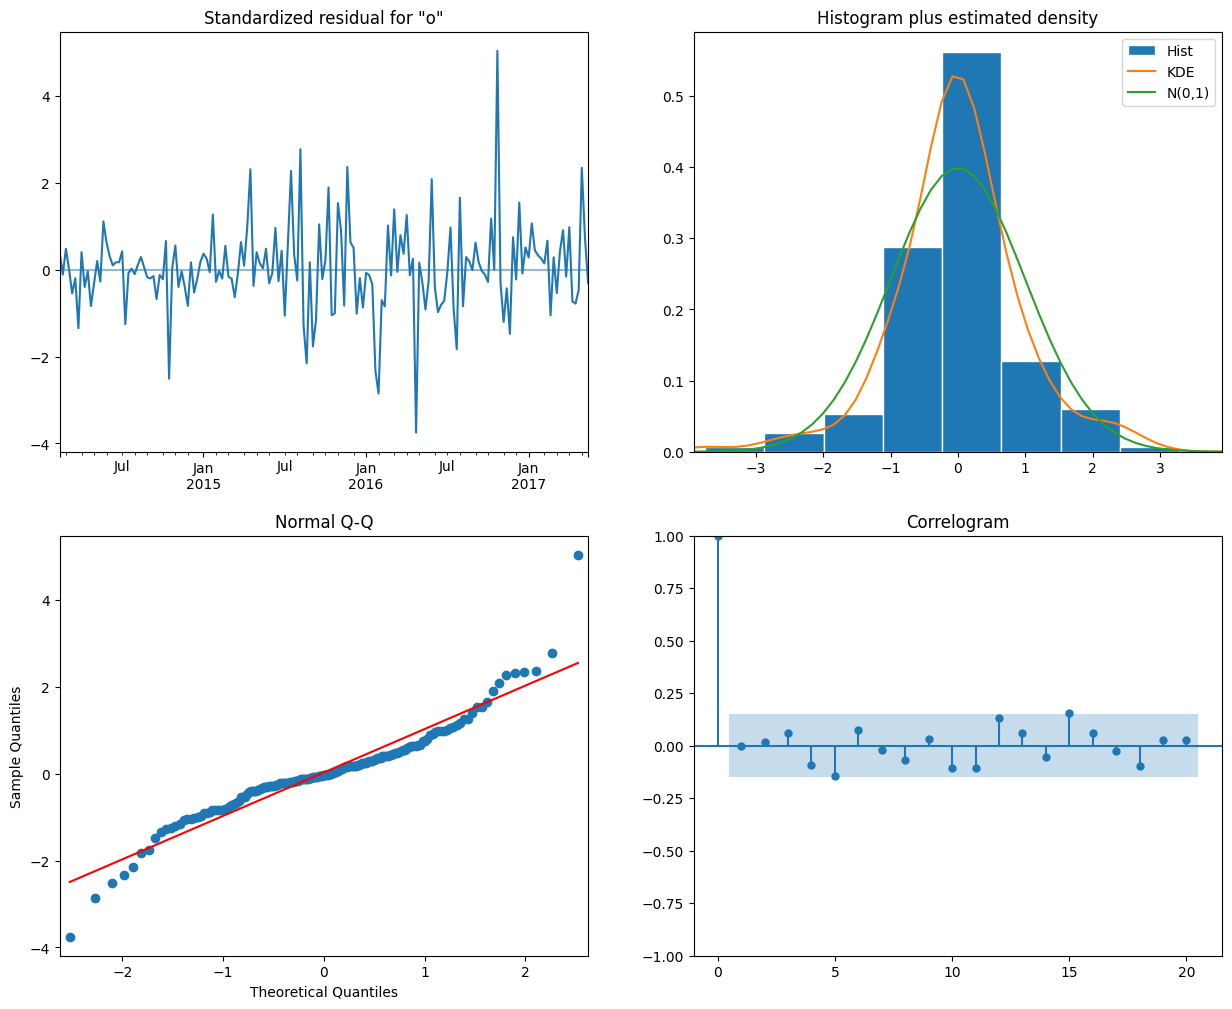

In [269]:
model_train_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

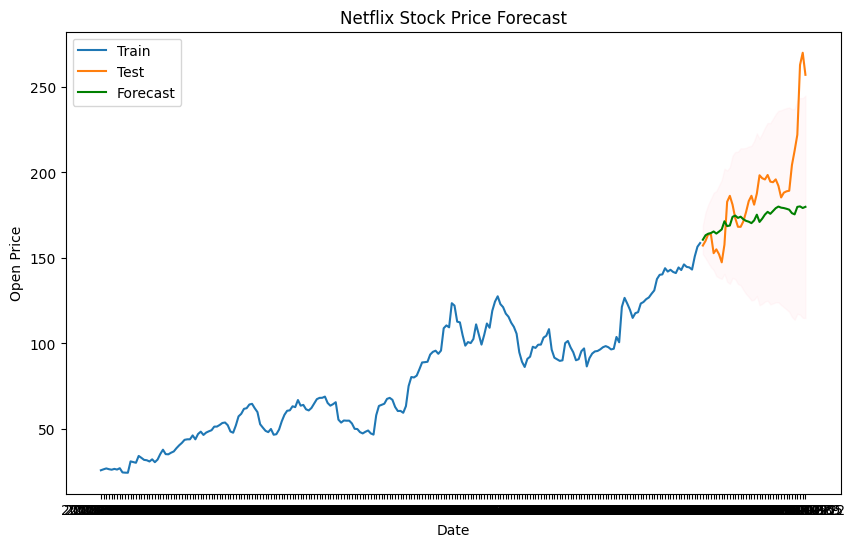

In [270]:
forecast = model_train_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Forecasting
predictions = model_train_fit.forecast(steps=TEST_SIZE)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['open'], label='Train')
plt.plot(test.index, test['open'], label='Test')
plt.plot(test.index, predictions, label='Forecast', color='green')
# Plotting the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.1)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
ax.set_xticklabels([])
plt.show()

In [271]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcul of errors between forecast and test
mae = mean_absolute_error(test['open'], predictions)
mse = mean_squared_error(test['open'] , predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Absolute Error: 18.87
Mean Squared Error: 793.01
Root Mean Squared Error: 28.16


###SARIMA (0,1,2)(0,1,1)(52)

In [272]:
model_train = SARIMAX(train, order=(0, 1, 2),seasonal_order=seasonal_order_3)
model_train_fit = model_train.fit(disp=False)
print(model_train_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                                 open   No. Observations:                  223
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 52)   Log Likelihood                -510.979
Date:                              Thu, 23 May 2024   AIC                           1029.958
Time:                                      18:40:40   BIC                           1042.501
Sample:                                  02-11-2013   HQIC                          1035.048
                                       - 05-15-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2439      0.086      2.831      0.005       0.075       0.413
ma.L2          0.00

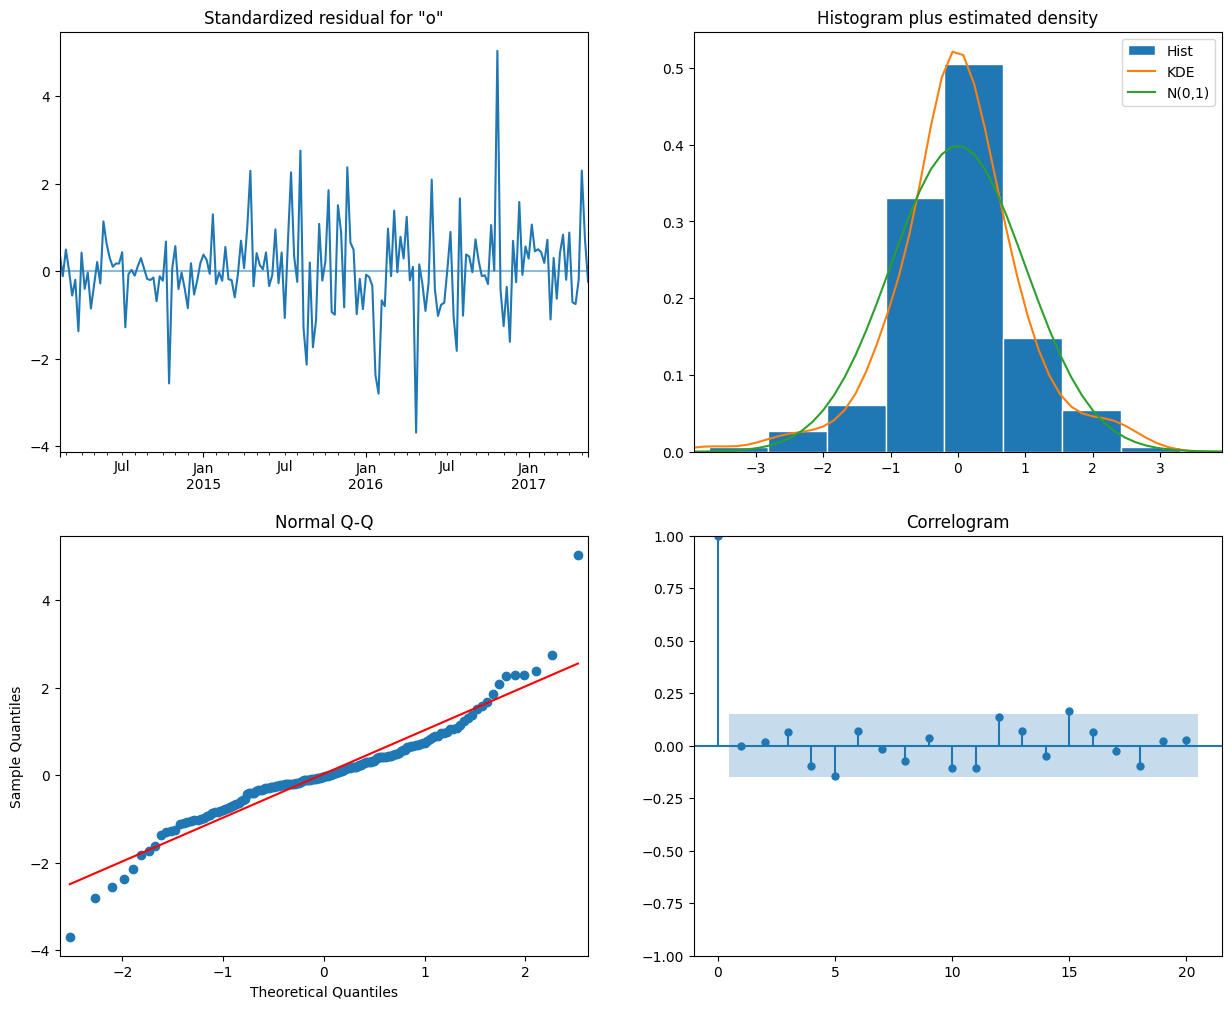

In [273]:
model_train_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

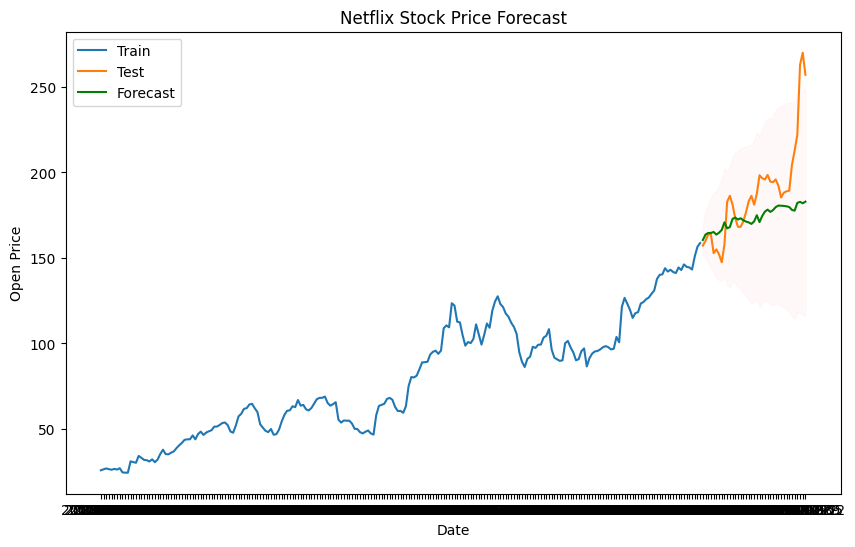

Mean Absolute Error: 18.16
Mean Squared Error: 737.70
Root Mean Squared Error: 27.16


In [274]:
forecast = model_train_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Forecasting
predictions = model_train_fit.forecast(steps=TEST_SIZE)

# Plotting results

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['open'], label='Train')
plt.plot(test.index, test['open'], label='Test')
plt.plot(test.index, predictions, label='Forecast', color='green')
# Plotting the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.1)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
ax.set_xticklabels([])
plt.show()


# Calcul of errors between forecast and test
mae = mean_absolute_error(test['open'], predictions)
mse = mean_squared_error(test['open'] , predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Fourth Model:
###SARIMA (0,1,2)(0,0,1)(52)

In [275]:
model_train = SARIMAX(train, order=(0, 1, 2),seasonal_order=seasonal_order_4)
model_train_fit = model_train.fit(disp=False)
print(model_train_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 open   No. Observations:                  223
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 52)   Log Likelihood                -618.422
Date:                              Thu, 23 May 2024   AIC                           1244.844
Time:                                      18:40:45   BIC                           1258.455
Sample:                                  02-11-2013   HQIC                          1250.339
                                       - 05-15-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1973      0.076      2.604      0.009       0.049       0.346
ma.L2         -0.02

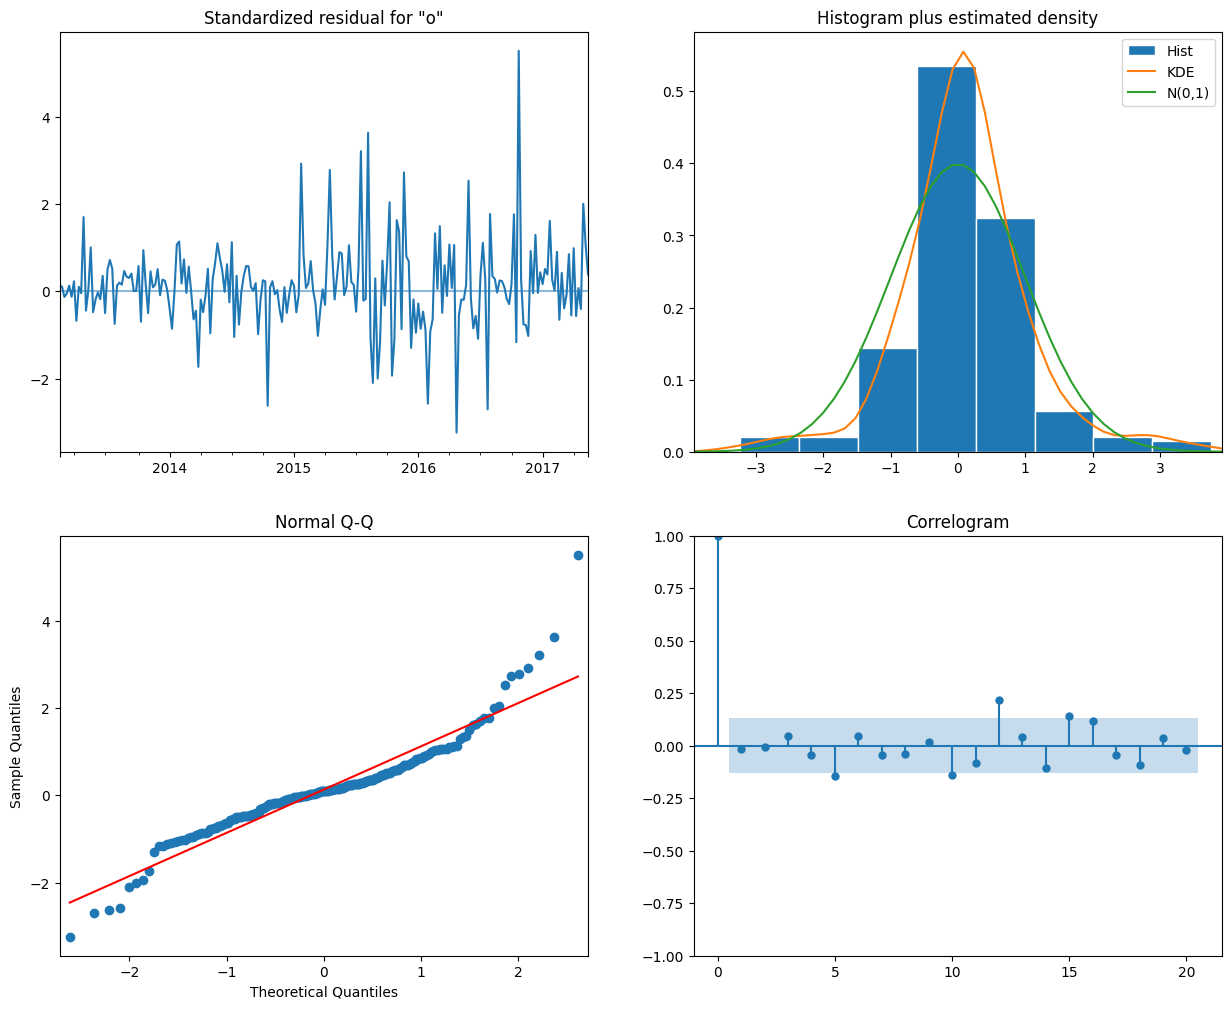

In [276]:
model_train_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

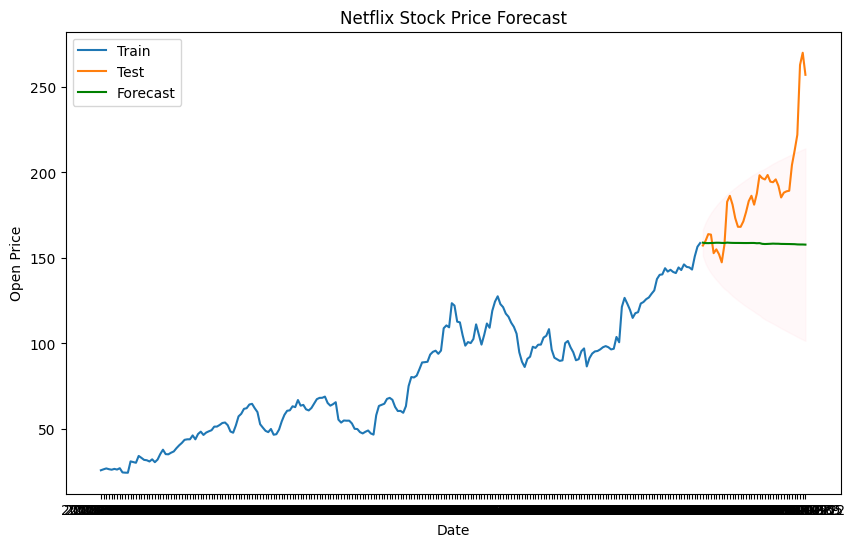

Mean Absolute Error: 30.37
Mean Squared Error: 1622.56
Root Mean Squared Error: 40.28


In [277]:
forecast = model_train_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Forecasting
predictions = model_train_fit.forecast(steps=TEST_SIZE)

# Plotting results

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['open'], label='Train')
plt.plot(test.index, test['open'], label='Test')
plt.plot(test.index, predictions, label='Forecast', color='green')
# Plotting the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.1)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
ax.set_xticklabels([])
plt.show()


# Calcul of errors between forecast and test
mae = mean_absolute_error(test['open'], predictions)
mse = mean_squared_error(test['open'] , predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

The fifth and last one:
###SARIMA (0,1,2)(1,1,0)(52)

In [278]:
model_train = SARIMAX(train, order=(0, 1, 2),seasonal_order=seasonal_order_5)
model_train_fit = model_train.fit(disp=False)
print(model_train_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                open   No. Observations:                  223
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -515.769
Date:                             Thu, 23 May 2024   AIC                           1039.538
Time:                                     18:40:54   BIC                           1052.081
Sample:                                 02-11-2013   HQIC                          1044.628
                                      - 05-15-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2735      0.081      3.393      0.001       0.116       0.431
ma.L2         -0.0151      

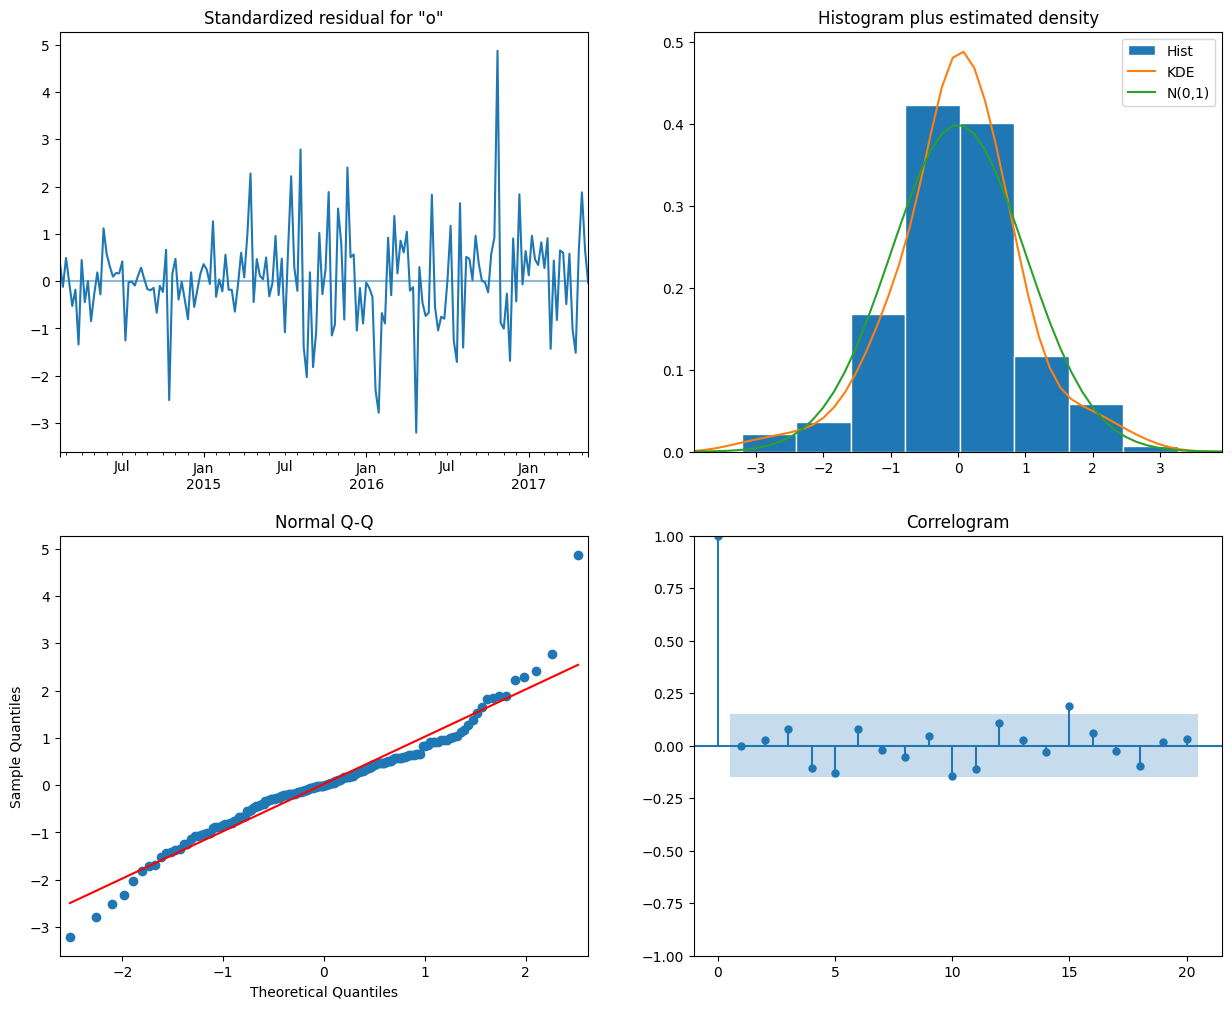

In [279]:
model_train_fit.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

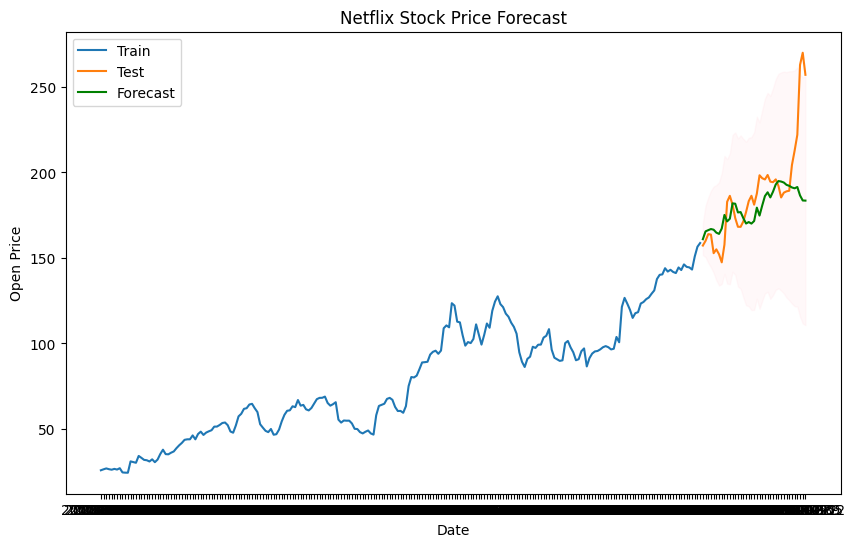

Mean Absolute Error: 15.32
Mean Squared Error: 613.45
Root Mean Squared Error: 24.77


In [280]:
forecast = model_train_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Forecasting
predictions = model_train_fit.forecast(steps=TEST_SIZE)

# Plotting results

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['open'], label='Train')
plt.plot(test.index, test['open'], label='Test')
plt.plot(test.index, predictions, label='Forecast', color='green')
# Plotting the confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.1)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
ax.set_xticklabels([])
plt.show()


# Calcul of errors between forecast and test
mae = mean_absolute_error(test['open'], predictions)
mse = mean_squared_error(test['open'] , predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

The best model is the first model:
SARIMA (0,1,2)(0,1,0)(52)
Mean Absolute Error: 13.31 Mean Squared Error: 350.79 Root Mean Squared Error: 18.73

###Prophet

In [281]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from prophet import Prophet
from prophet.plot import plot, plot_components
!pip install prophet
import prophet
from sklearn.metrics import mean_absolute_error
import itertools

In [282]:
# Create a copy of the sliced DataFrame
df = stock_df[['date', 'open']].copy()

# Rename the columns
df.columns = ['ds', 'y']

# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,ds,y
0,2013-02-11,25.766000
1,2013-02-18,26.336375
2,2013-02-25,26.836840
3,2013-03-04,26.393700
4,2013-03-11,26.093420


In [283]:
# split data
train = df[df['ds'] < pd.Timestamp('2017-06-01')]
test = df[df['ds'] >= pd.Timestamp('2017-06-01')]
print(f"Number of weeks in train data: {len(train)}")
print(f"Number of weeks in test data: {len(test)}")

Number of weeks in train data: 225
Number of weeks in test data: 37


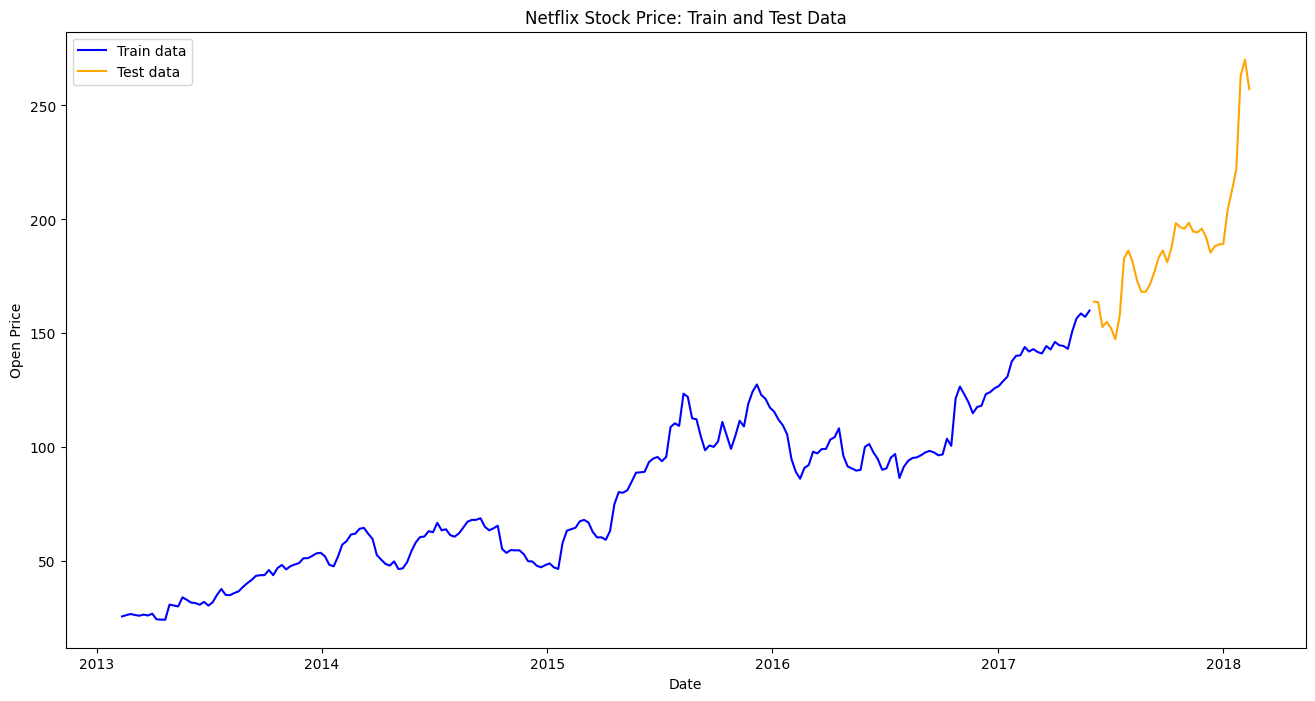

In [284]:
# Plotting the test and the train

plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Train data', color='blue')
plt.plot(test['ds'], test['y'], label='Test data', color='orange')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Netflix Stock Price: Train and Test Data')
plt.legend()
plt.show()

Such as we did in SARIMA, we would like to exploit all the available parameters and choose the one minimizing the MAE.
That's why, we will use a grid to choose the paramaters of the Prophet Model.

In [285]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
future = test[['ds']]
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store results
results = []

# Perform cross-validation for each combination of parameters
for params in all_params:
    model = Prophet(**params)
    model.add_country_holidays(country_name='US')
    model.fit(train)
    forecast = model.predict(future)
    mae = mean_absolute_error(test['y'], forecast['trend'])
    # Store results
    results.append((params, mae))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvo9owdy/7mshkqtt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvo9owdy/gaq9t44j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19200', 'data', 'file=/tmp/tmpbvo9owdy/7mshkqtt.json', 'init=/tmp/tmpbvo9owdy/gaq9t44j.json', 'output', 'file=/tmp/tmpbvo9owdy/prophet_model0690bgvd/prophet_model-20240523184105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

In [286]:
best_params = min(results, key=lambda x: x[1])
print(f"Best Parameters: {best_params[0]}")
print(f"Mean Absolute Error: {best_params[1]}")

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Mean Absolute Error: 11.33023316282663


In [287]:
best_model = Prophet(**best_params[0])
best_model.fit(train)

future = best_model.make_future_dataframe(periods=len(test), freq='W')
forecast = best_model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvo9owdy/i9owdm90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvo9owdy/yigodequ.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27064', 'data', 'file=/tmp/tmpbvo9owdy/i9owdm90.json', 'init=/tmp/tmpbvo9owdy/yigodequ.json', 'output', 'file=/tmp/tmpbvo9owdy/prophet_model28ogs6_c/prophet_model-20240523184114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


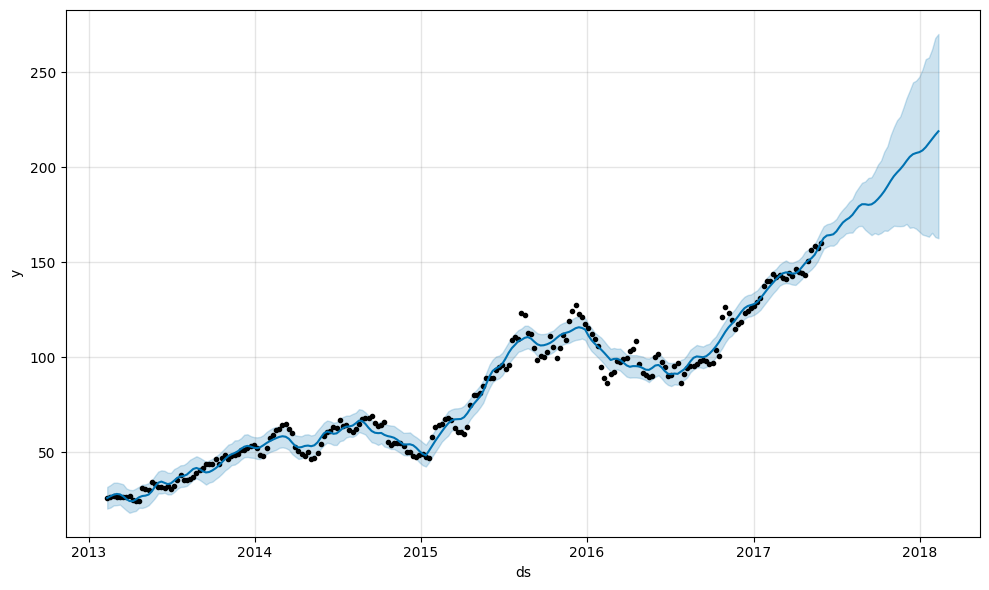

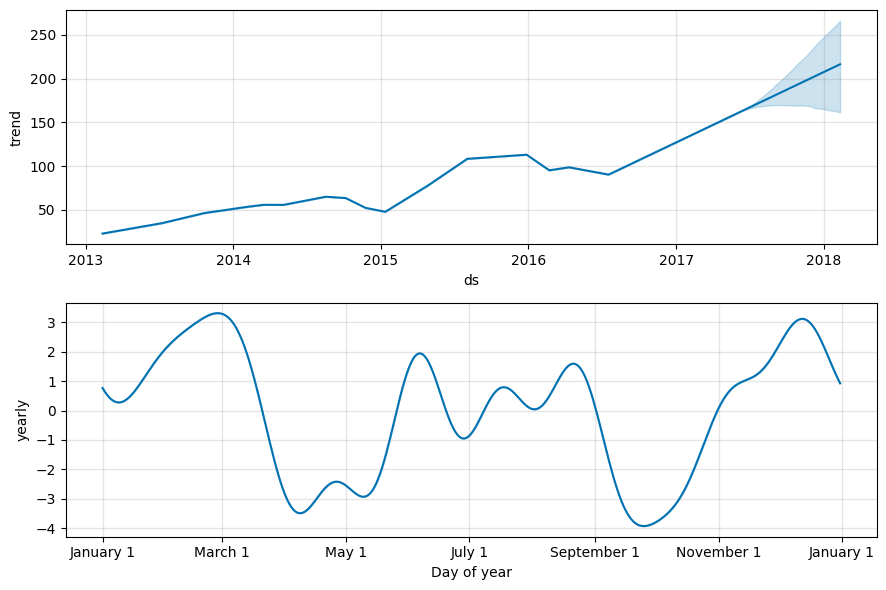

In [288]:
from prophet.plot import plot, plot_components
from matplotlib import pyplot as plt

plot(best_model, forecast)               # Plot the forecast
plot_components(best_model, forecast)    # Plot the forecast components
plt.show()

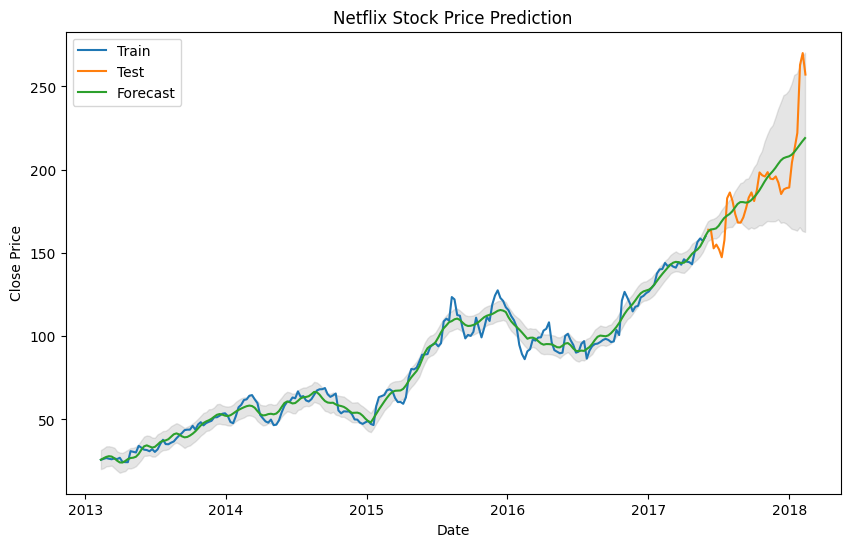

In [289]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train['ds'], train['y'], label='Train')
ax.plot(test['ds'], test['y'], label='Test')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
ax.set_title('Netflix Stock Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()

plt.show()

The best model is:
Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Mean Absolute Error: 11.33023316282663

###Part 3 Exogenous

We have chosen to introduce to our data set the variable representing the number of moovies and series added each month to Netflix. We consider that the relation between Netlixs stock market value and this variable is logical. We are going to figure out the impact the number of moovies and series added each month has on the stock value.

In [290]:
# Ensure the 'date' column is in datetime format
stock_df = stock_df[['open', 'date']].copy()
stock_df['date'] = pd.to_datetime(stock_df['date'])

# Set the 'date' column as the index
stock_df.set_index('date', inplace=True)

# Resample to monthly frequency and calculate the mean of the 'open' column
monthly_mean = stock_df['open'].resample('M').mean()

# Create a new DataFrame from the resampled data
monthly_mean_open = pd.DataFrame({
    'mean_open': monthly_mean.values,
    'month': monthly_mean.index
})

# Format the 'month' column to display the last day of each month
# monthly_mean_open['month'] = monthly_mean_open['month'].dt.strftime('%Y-%m-%d')
monthly_mean_open['month'] = pd.to_datetime(monthly_mean_open['month'], format='%Y-%m-%d')

# Reorder the columns
monthly_mean_open = monthly_mean_open[['mean_open', 'month']]

We have decided to aggregate the stock value to its monthly average in order to be able to work with our new variable.

In [291]:
releases_df = pd.read_csv('209369909_931203129_2.csv', sep=',')
releases_df['date_added'] = releases_df['date_added'].str.strip()
# Keeping only 'title' and 'date_added' columns
releases_df = releases_df[['title', 'date_added']]

# Converting 'date_added' column to real date format
releases_df['date_added'] = pd.to_datetime(releases_df['date_added'], format='%B %d, %Y')

In [292]:
# Extract the month and year from the date_added column
# releases_df['month'] = releases_df['date_added'].dt.to_period('M')

releases_df['month'] = pd.to_datetime(releases_df['date_added'])
releases_df['month'] = releases_df['date_added'] + pd.offsets.MonthEnd(0)

# Group by the month and count the number of titles for each month
monthly_counts = releases_df.groupby('month').size().reset_index(name='sum')

# Rename the columns for clarity
monthly_counts.columns = ['month', 'sum']
# monthly_counts['month'] = monthly_counts['month'].dt.strftime('%Y-%m')

print(monthly_counts.head())

       month  sum
0 2008-01-31    1
1 2008-02-29    1
2 2009-05-31    1
3 2009-11-30    1
4 2010-11-30    1


In [293]:
monthly_mean_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   mean_open  61 non-null     float64       
 1   month      61 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [294]:
monthly_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   108 non-null    datetime64[ns]
 1   sum     108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


Here we depict the new variable. The month and the number of new items added to Netflix

In [295]:
# Merge df11 and df21 based on their 'month' column
merged_df = pd.merge(monthly_mean_open, monthly_counts, on='month', how='inner')

merged_df['month'] = merged_df['month'].dt.to_period('M').dt.to_timestamp('M')

filtered_df = merged_df[merged_df['month'] >= '2014-06-01']
filtered_df.head(3)

,mean_open,month,sum
9,61.104748,2014-06-30,1
10,63.968179,2014-07-31,1
11,63.769730,2014-08-31,1


Merging the two dataset based on their month

In [296]:
# Optionally, set 'month' as the index if needed and ensure it is a DatetimeIndex
filtered_df.set_index('month', inplace=True)

# Ensure the index is of type DatetimeIndex
filtered_df.index = pd.DatetimeIndex(filtered_df.index)
all_months = pd.date_range(start=filtered_df.index.min(), end=filtered_df.index.max(), freq='M')
filtered_df = filtered_df.reindex(all_months)

filtered_df.index.freq = 'M'

Setting indexes and frequency for the model we are using

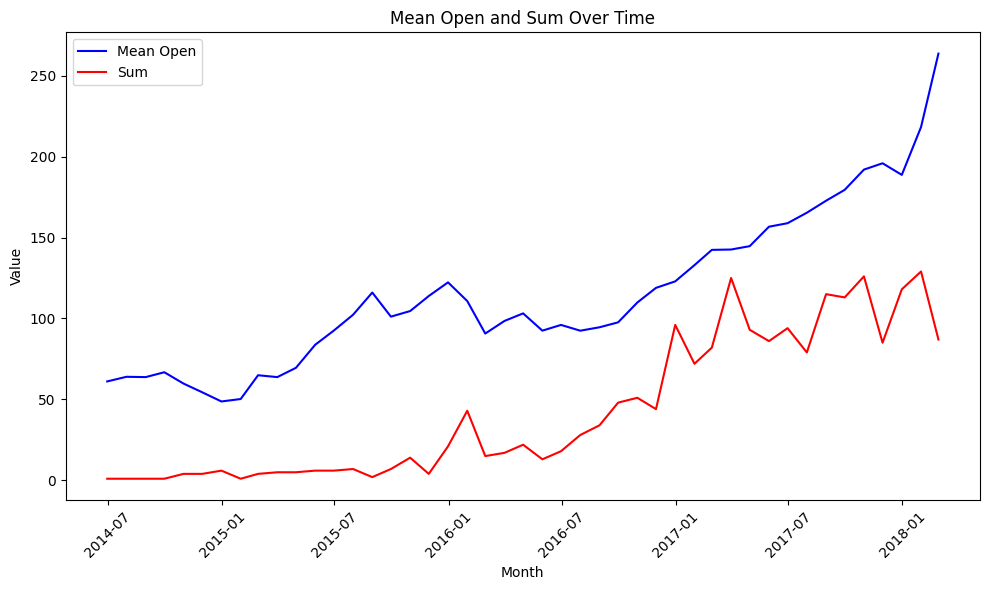

In [297]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean_open
plt.plot(filtered_df.index, filtered_df['mean_open'], color='blue', label='Mean Open')

# Plot sum
plt.plot(filtered_df.index, filtered_df['sum'], color='red', label='Sum')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Mean Open and Sum Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Depiction of the stock monthly value next to the number of items added to Netflix. We may see a trend in which both the graphs have similar tendencies to grow together.

In [298]:
pip install skforecast

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [299]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [300]:
steps = int(0.15*len(filtered_df))
data_train = filtered_df.iloc[:-steps, :]
data_test  = filtered_df.iloc[-steps:, :]

Setting train and test sets

In [301]:
# Create and fit forecaster
# ==============================================================================

forecaster = ForecasterAutoreg(
                #  regressor = RandomForestRegressor(random_state=123),
                 regressor = RandomForestRegressor(n_estimators=20, max_features=6),
                 lags      = 15
             )

forecaster.fit(
    y    = data_train['mean_open'],
    exog = data_train['sum']
)

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_features=6, n_estimators=20) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: sum 
Training range: [Timestamp('2014-06-30 00:00:00'), Timestamp('2017-08-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-23 18:41:29 
Last 

We create and fit the model, while training it on our train set.

In [302]:
predictions = forecaster.predict(
                  steps = steps,
                  exog  = data_test['sum']
              )

predictions.head(10)

2017-09-30    165.285688
2017-10-31    166.027438
2017-11-30    164.160003
2017-12-31    163.606383
2018-01-31    163.606383
2018-02-28    162.541633
Freq: M, Name: pred, dtype: float64

Prediction table

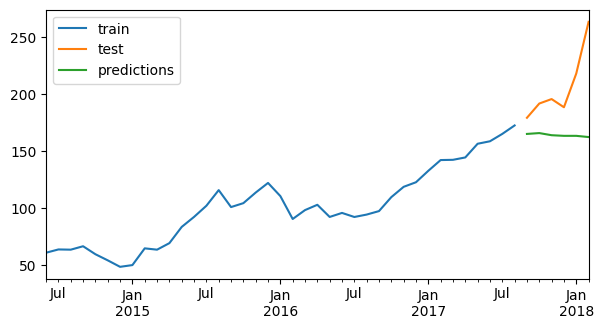

In [303]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train['mean_open'].plot(ax=ax, label='train')
data_test['mean_open'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

Here we got a graph comparing the model prediction for the stock value when using the exogenous variable. We may see that the model isn't performing very well, the test graph if diverging in another direction compared to the test graph. We understand that the exogenous variable is not s good "friend" in this case.

In [304]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['mean_open'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 2618.1679395312863


The minimum quared error large value confirms our claims.